In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import plotly.express as px
import itertools
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
from sklearn import metrics

In [2]:
# import dataset
data = pd.read_csv('data1.csv')

In [3]:
data.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


In [4]:
# display complete row and columns
pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',None)

In [5]:
# check missing values
data.isnull().sum()
# because missing values shown as "?" in this dataset

age               0
workclass         0
fnlwgt            0
education         0
education.num     0
marital.status    0
occupation        0
relationship      0
race              0
sex               0
capital.gain      0
capital.loss      0
hours.per.week    0
native.country    0
income            0
dtype: int64

In [6]:
# assign all the "?" to NA
data[data == '?'] = np.nan
data.head()
# report number of missing values
data.isnull().sum()

age                  0
workclass         1836
fnlwgt               0
education            0
education.num        0
marital.status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital.gain         0
capital.loss         0
hours.per.week       0
native.country     583
income               0
dtype: int64

In [8]:
# rename some of the columns
data.rename(columns={'native.country':'native_country', 'education.num':'education_num','marital.status':'marital_status','capital.gain':'capital_gain','capital.loss':'capital_loss','hours.per.week':'hours_per_week'}, inplace=True)

In [9]:
# drop rows with missing values
data = data[~data.workclass.isnull()].copy()
data = data[~data.occupation.isnull()].copy()
data = data[~data.native_country.isnull()].copy()

In [10]:
# change the response variable into binary
def convert_to_binary(x):
    if x=='<=50K':
        return 0
    if x=='>50K':
        return 1

data['income'] = data['income'].apply(convert_to_binary)

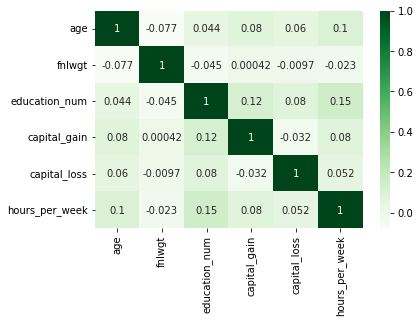

In [11]:
# Visualizing the relationship between the numerical variables
data[['age','workclass','fnlwgt','education','education_num','marital_status','occupation','relationship','race','sex','capital_gain','capital_loss','hours_per_week','native_country']].corr()

sns.heatmap(data[['age','workclass','fnlwgt','education','education_num','marital_status','occupation','relationship','race','sex','capital_gain','capital_loss','hours_per_week','native_country']].corr(),annot=True,cmap='Greens')
plt.rcParams["figure.figsize"] = (10,8)
plt.show()

# this step to see if the variables are independent
# no strong correlation
# the strongest correlation is between age and hours_per_week, which is 0.1

In [12]:
# check the data
data.head()
# clear correlation between education and education_num, therefore remove education
data = data.drop(columns=['education'])

In [13]:
# train / test split
X = data.iloc[:, 0:13]
y = data.iloc[:, 13]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [14]:
# categorical variables

categorical = ['workclass','marital_status', 'occupation', 'relationship', 'race', 'sex', 'native_country']
for feature in categorical:
        le = preprocessing.LabelEncoder()
        X_train[feature] = le.fit_transform(X_train[feature])
        X_test[feature] = le.transform(X_test[feature])

In [15]:
# Standardize
scaler = StandardScaler()

X_train = pd.DataFrame(scaler.fit_transform(X_train), columns = X.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns = X.columns)

In [16]:
X_train.head()

,age,workclass,fnlwgt,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country
0,0.344829,-0.205887,-0.418054,1.130490,-0.389069,-0.735118,-0.884680,0.383823,0.694287,-0.145601,-0.217041,-0.077743,0.265743
1,-0.340678,-0.205887,-1.466544,-0.435995,0.946804,-0.239140,-0.258795,0.383823,0.694287,-0.145601,-0.217041,1.589099,0.265743
2,-0.416845,-0.205887,2.127440,-2.785723,1.614740,0.256838,1.618861,0.383823,-1.440327,-0.145601,-0.217041,-0.077743,-1.864253
3,0.192494,2.950306,-0.784512,1.522112,-0.389069,0.752816,-0.884680,0.383823,0.694287,0.846928,-0.217041,1.589099,0.265743
4,-0.340678,-2.310016,0.312796,-0.044374,-1.724942,1.000806,0.992976,0.383823,0.694287,-0.145601,-0.217041,2.589204,0.265743


In [ ]:
# find the best number of estimators
# Define random forest
rf_fit1 = RandomForestRegressor(n_estimators=50, 
                                      criterion='mse',
                                      max_depth=None,
                                      min_samples_leaf=1,
                                      min_weight_fraction_leaf=0.0,
                                      max_features='sqrt', # For a proper random forest
                                      max_leaf_nodes=None,
                                      min_impurity_decrease=0.0,
                                      bootstrap=True,
                                      oob_score=True,
                                      random_state=1,
                                      )

# Range of `n_estimators` values to explore.
min_estimators = 50
max_estimators = 500

# Define error list
error_rate = []

# iterate over forest
for i in range(min_estimators, max_estimators + 1):
    rf_fit1.set_params(n_estimators=i)
    rf_fit1.fit(X_train, y_train)

    # Record the OOB error for each `n_estimators=i` setting.
    oob_error = 1 - rf_fit1.oob_score_
    error_rate.append((i, oob_error))

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: 

In [ ]:
# Plot
xs, ys = zip(*error_rate)
plt.plot(xs, ys, label='Random Forest Regressor')

plt.xlim(min_estimators, max_estimators)
plt.xlabel("Number of trees")
plt.ylabel("OOB error rate")
plt.legend(loc="upper right")
plt.show()

In [ ]:
# Final forest
rf_best_fit = RandomForestRegressor(n_estimators=400, 
                                       criterion='mse',
                                      max_depth=None,
                                      min_samples_leaf=1,
                                      min_weight_fraction_leaf=0.0,
                                      max_features='sqrt', # For a proper random forest
                                      max_leaf_nodes=None,
                                      min_impurity_decrease=0.0,
                                      bootstrap=True,
                                      oob_score=True,
                                      random_state=1,
                                      
                                      )

rf_best_fit.fit(X_train, y_train)

# Predict over test set
pred_test = rf_best_fit.predict(X_test)

# Mean squared error
mse_rf = np.square(np.subtract(y_test,pred_test)).mean()
mse_rf

In [ ]:
rf_pred_train = rf_best_fit.predict(X_train)

ssr = sum(np.square(np.subtract(rf_pred_train,y_train.mean())))
sst = sum(np.square(np.subtract(y_train,y_train.mean())))
r_squared = ssr/sst
r_squared

In [ ]:
# visualization
rf_y_pred_test = rf_best_fit.predict(X_test)
rf_y_pred_test

In [ ]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, rf_y_pred_test)

roc_auc = auc(fpr, tpr)
print("Area under the ROC curve : %f" % roc_auc)

In [ ]:
# Variable importance
importances = rf_best_fit.feature_importances_
indices = np.argsort(importances)[::-1] 

f, ax = plt.subplots(figsize=(5, 20))
plt.title("Variable Importance - Random Forest")
sns.set_color_codes("pastel")
sns.barplot(y=[X_train.columns[i] for i in indices], 
            x=importances[indices], 
            label="Total", color="b")
ax.set(ylabel="Variable",
       xlabel="Variable Importance (Entropy)")
sns.despine(left=True, bottom=True)

# country, race and sex are the least important variables

In [ ]:
logit_fit = LogisticRegression(penalty='l2')
logit_fit.fit(X_train, y_train)
pred_train = logit_fit.predict(X_train)

ssr = sum(np.square(np.subtract(pred_train,y_train.mean())))
sst = sum(np.square(np.subtract(y_train,y_train.mean())))
r_squared = ssr/sst
r_squared

In [ ]:
logit_pred_test = logit_fit.predict(X_test)
accuracy_score(y_test, logit_pred_test)

In [ ]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, logit_pred_test)

roc_auc = auc(fpr, tpr)
print("Area under the ROC curve : %f" % roc_auc) 